In [5]:
on_google_colab = True
if on_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  !ls '/content/drive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
 Classroom	   'Getting started.pdf'		       tub
'Colab Notebooks'  'New Doc 2020-01-23 12.55.46 (1).pdf.pdf'   tub.zip
 data_lidc.pickle  'New Doc 2020-01-23 12.55.46.pdf.pdf'       vrinda_aarhus


In [0]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 89kB/s 


In [6]:
from load_LIDC_data import LIDC_IDRI

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = LIDC_IDRI(dataset_location = '/content/drive/My Drive/')
# test_dataset = LIDC_IDRI(dataset_location = '/content/drive/My Drive/', training=False)
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
test_loader = DataLoader(train_dataset, batch_size=1, sampler=test_sampler)
print("Number of training/test patches:", (len(train_indices),len(test_indices)))

Loading file data_lidc.pickle
Number of training/test patches: (13587, 1509)


In [0]:
from importlib import reload
import model
# reload(model)

net = model.ProbU_Net(in_channels=1, out_channels=1, latent_dim=6)
net.to(device)
optimizer = torch.optim.Adam(net.parameters())

In [0]:
loss_history = []
import random
for epoch in range(15):
    train_loss = 0.0
    for step, (patch, mask, _) in enumerate(train_loader):
        # print(mask.shape) 
        mask = mask[:,random.randint(0,3),:,:]
        patch = patch.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        net.forward(patch, mask, train=True)
        loss = net.loss(mask, beta=10.0)
        x = loss.item()
        train_loss += x
        if (step%100==0):
          print('(%d, %5d) item-loss: %.9f'%(epoch + 1, step + 1, x))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('[%d] epoch-loss: %.9f'%(epoch + 1, train_loss))
    loss_history.append(train_loss)
print('Finished Training')

(1,     1) item-loss: 8.423168182
(1,   101) item-loss: 0.446951568
(1,   201) item-loss: 0.203137428
(1,   301) item-loss: 0.267424643
(1,   401) item-loss: 0.189708248
(1,   501) item-loss: 0.441613406
(1,   601) item-loss: 0.095321514
(1,   701) item-loss: 0.253150612
(1,   801) item-loss: 0.081776738
(1,   901) item-loss: 0.097086750
(1,  1001) item-loss: 0.053719301
(1,  1101) item-loss: 0.076006450
(1,  1201) item-loss: 0.116413131
(1,  1301) item-loss: 0.280113518
(1,  1401) item-loss: 0.208951876
(1,  1501) item-loss: 0.176974133
(1,  1601) item-loss: 0.047725007
[1] epoch-loss: 574.763042245
(2,     1) item-loss: 0.045435417
(2,   101) item-loss: 0.039208435
(2,   201) item-loss: 0.229567215
(2,   301) item-loss: 0.073127829
(2,   401) item-loss: 0.090360768
(2,   501) item-loss: 0.062274136
(2,   601) item-loss: 0.065386832
(2,   701) item-loss: 0.141716778
(2,   801) item-loss: 0.051304519
(2,   901) item-loss: 0.077240884
(2,  1001) item-loss: 0.045262840
(2,  1101) item-lo

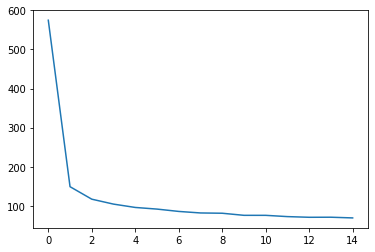

In [0]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

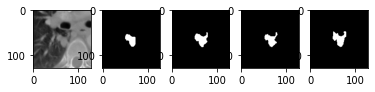

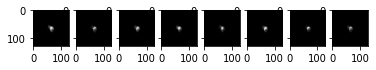

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

def sigmoid(array):
  return 1/(1+np.exp(-array))

ns = 8
for step, (patch, masks, _) in enumerate(test_loader):
    patch = patch.to(device)
    recon = [sigmoid(x.cpu().detach().numpy()) for x in net.reconstruct(patch, num_samples=ns)]
    masks = masks.cpu().detach().numpy()
    patch = patch.cpu().detach().numpy()
    # print(masks.shape)
    f = plt.figure()
    f.add_subplot(1,5,1)
    plt.imshow(patch[0][0],cmap='gray')
    for i in range(4):
      f.add_subplot(1,5,i+2)
      plt.imshow(masks[0,i,:,:],cmap='gray')
    
    g = plt.figure()
    for i in range(ns):
      g.add_subplot(1,ns,i+1)
      plt.imshow(recon[i][0][0],cmap='gray')

    break


In [0]:
PATH = 'punet.pth'
torch.save(net.state_dict(), PATH)

In [7]:
import model
PATH = 'punet.pth'
net = model.ProbU_Net(in_channels=1, out_channels=1, latent_dim=6)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

def sigmoid(array):
  return 1/(1+np.exp(-array))

ns = 8
for step, (patch, masks, _) in enumerate(test_loader):
    patch = patch.to(device)
    recon = [sigmoid(x.cpu().detach().numpy()) for x in net.reconstruct(patch, num_samples=ns)]
    masks = masks.cpu().detach().numpy()
    patch = patch.cpu().detach().numpy()
    # print(masks.shape)
    f = plt.figure()
    f.add_subplot(1,5,1)
    plt.imshow(patch[0][0],cmap='gray')
    for i in range(4):
      f.add_subplot(1,5,i+2)
      plt.imshow(masks[0,i,:,:],cmap='gray')
    
    g = plt.figure()
    for i in range(ns):
      g.add_subplot(1,ns,i+1)
      plt.imshow(recon[i][0][0],cmap='gray')

    break

AttributeError: ignored